In [33]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

DATASET

In [34]:
import torch
from torchvision import datasets, transforms

# Define the transformation for the training set (with data augmentation)
transform_train = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Define the transformation for the validation set (without augmentation)
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset with transformations
training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Data loaders
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=100, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


CNN MODEL

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # Convolutional Layers with Batch Normalization
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)  # Input channels: 3, Output channels: 64
        self.bn1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # Input channels: 64, Output channels: 128
        self.bn2 = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  # Input channels: 128, Output channels: 256
        self.bn3 = nn.BatchNorm2d(256)
        
        # Pooling Layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(256 * 4 * 4, 1024)  # Input size: 256x4x4, Output size: 1024
        self.bn_fc1 = nn.BatchNorm1d(1024)
        
        self.fc2 = nn.Linear(1024, 10)  # Output size: 10 (number of classes)
        
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        # Flatten the image
        x = x.view(-1, 256 * 4 * 4)
        
        # Fully connected layers with Batch Normalization
        x = F.relu(self.bn_fc1(self.fc1(x)))
        
        x = self.fc2(x)
        return x


MODEL LOADING

In [36]:
# Load the model architecture
model = CNN()

# Load the trained model's state dict
model.load_state_dict(torch.load("best_model_final.pth"))

# Ensure the model is in evaluation mode
model.eval()

C:\Users\7501\AppData\Local\Temp\ipykernel_21984\1076258511.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_final.pth"))


CNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (bn_fc1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

LATENCY OF PYTORCH MODEL

In [38]:
import time
import numpy as np
import torch

# Function to measure PyTorch latency with a batch of validation data
def measure_pytorch_latency(model, data_loader, num_runs=100):
    latencies = []
    model.eval()
    device = next(model.parameters()).device  # Get the device of the model
    with torch.no_grad():
        for _ in range(num_runs):
            inputs, _ = next(iter(data_loader))  # Take a batch of validation data
            inputs = inputs.to(device)  # Move inputs to the same device as the model
            start_time = time.time()
            _ = model(inputs)  # Forward pass
            latencies.append(time.time() - start_time)
    return latencies

# Load your model (replace with your actual model)
pytorch_latencies = measure_pytorch_latency(model, validation_loader)
pytorch_avg_latency = np.mean(pytorch_latencies)

print(f"PyTorch Average Latency: {pytorch_avg_latency:.6f} seconds")


PyTorch Average Latency: 0.156344 seconds


EXPORT PYTORCH TO ONNX

In [39]:
# Assuming the model is loaded as 'model' and 'validation_loader' is defined

# Load a batch of validation data
inputs, _ = next(iter(validation_loader))  # Get the first batch of data from the validation loader

# Export the trained PyTorch model to ONNX using the validation batch
onnx_path = "best_model_final.onnx"

torch.onnx.export(
    model,
    inputs,  # Use the validation batch as input
    onnx_path,
    export_params=True,
    opset_version=11,
    input_names=["input"],
    output_names=["output"]
)

print(f"Model successfully exported to {onnx_path}")


Model successfully exported to best_model_final.onnx


In [40]:
import onnx
model = onnx.load("best_model_final.onnx")
onnx.checker.check_model(model)


CONVERT ONNX TO TENSORRT


trtexec --onnx=best_model_final.onnx --saveEngine=best_model_final.trt --fp16

LATENCY FOR TENSORRT

In [41]:
import time
import numpy as np
import torch
import tensorrt as trt

# Load the TensorRT engine
def load_engine(engine_path):
    runtime = trt.Runtime(trt.Logger(trt.Logger.WARNING))
    try:
        with open(engine_path, 'rb') as f:
            engine = runtime.deserialize_cuda_engine(f.read())
        if engine is None:
            raise ValueError("Failed to deserialize the engine.")
        return engine
    except Exception as e:
        print(f"Error loading engine: {e}")
        return None


# Perform inference and measure latency
def infer_and_measure_latency(engine, validation_loader):
    context = engine.create_execution_context()
    
    # Lists to store input and output bindings
    input_bindings = []
    output_bindings = []
    
    # Iterate through all tensors in the engine
    for i in range(engine.num_io_tensors):
        tensor_name = engine.get_tensor_name(i)
        size = trt.volume(engine.get_tensor_shape(tensor_name))  # Get the tensor size (volume)
        dtype = trt.nptype(engine.get_tensor_dtype(tensor_name))  # Get the tensor data type
        
        # Check whether the tensor is an input or output
        if engine.get_tensor_mode(tensor_name) == trt.TensorIOMode.INPUT:
            input_bindings.append((tensor_name, size, dtype))
        else:
            output_bindings.append((tensor_name, size, dtype))
    
    # Assuming the input shape is (batch_size, 3, 32, 32) and output shape is (batch_size, 10)
    # You may adjust this based on your model
    input_binding = input_bindings[0]  # First input binding
    output_binding = output_bindings[0]  # First output binding
    
    # Get the input shape directly from the engine
    input_shape = engine.get_tensor_shape(input_binding[0])
    batch_size = input_shape[0]  # The batch size is the first dimension
    
    # Get the output shape directly from the engine
    output_shape = engine.get_tensor_shape(output_binding[0])

    # Convert TensorRT Dims to tuple
    input_shape_tuple = tuple(input_shape)
    output_shape_tuple = tuple(output_shape)

    # Allocate host and device buffers
    d_input = torch.zeros(input_shape_tuple, dtype=torch.float32).cuda()  # Device input memory on GPU
    d_output = torch.zeros(output_shape_tuple, dtype=torch.float32).cuda()  # Device output memory on GPU

    latencies = []
    for inputs, _ in validation_loader:
        inputs = inputs.cuda()  # Move the inputs to GPU
        
        # Copy inputs to device memory
        d_input.copy_(inputs)
        
        start_time = time.perf_counter()
        context.execute_v2([d_input.data_ptr(), d_output.data_ptr()])  # Pass device memory pointers
        end_time = time.perf_counter()
        
        latencies.append(end_time - start_time)
    
    avg_latency = np.mean(latencies)
    return avg_latency

# Example usage
engine_path = "best_model_final_1.trt"
engine = load_engine(engine_path)
average_latency = infer_and_measure_latency(engine, validation_loader)
print(f"Average latency per batch: {average_latency:.6f} seconds")


Average latency per batch: 0.014679 seconds


COMPARISION

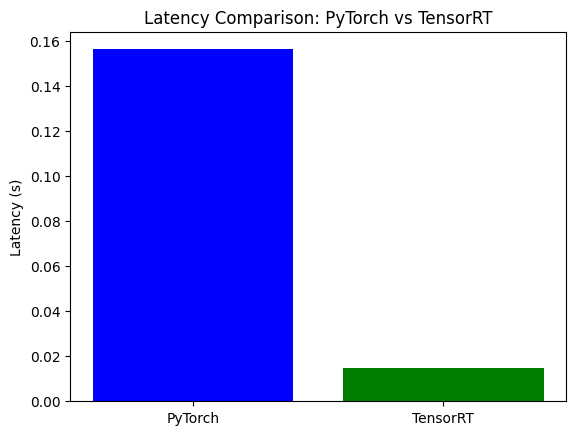

In [43]:
import matplotlib.pyplot as plt

# Plot Latency Comparison
plt.bar(["PyTorch", "TensorRT"], [pytorch_avg_latency , average_latency ], color=['blue', 'green'])
plt.ylabel("Latency (s)")
plt.title("Latency Comparison: PyTorch vs TensorRT")
plt.show()


ACCURACY VERIFICATION

In [44]:
import torch
import numpy as np
import tensorrt as trt

# Load the PyTorch model
model = CNN()  # Replace with your model class
model.load_state_dict(torch.load("best_model_final.pth"))
model.to(device)
model.eval()

# Load the TensorRT engine
def load_trt_engine(engine_path):
    runtime = trt.Runtime(trt.Logger(trt.Logger.WARNING))
    try:
        with open(engine_path, 'rb') as f:
            engine = runtime.deserialize_cuda_engine(f.read())
        if engine is None:
            raise ValueError("Failed to deserialize the engine.")
        return engine
    except Exception as e:
        print(f"Error loading engine: {e}")
        return None

# Function to perform inference with the TensorRT engine
def infer_with_trt(engine, validation_loader):
    context = engine.create_execution_context()
    
    # Lists to store input and output bindings
    input_bindings = []
    output_bindings = []
    
    # Iterate through all tensors in the engine to retrieve input and output bindings
    for i in range(engine.num_io_tensors):
        tensor_name = engine.get_tensor_name(i)
        size = trt.volume(engine.get_tensor_shape(tensor_name))  # Get tensor size (volume)
        dtype = trt.nptype(engine.get_tensor_dtype(tensor_name))  # Get tensor data type
        
        # Classify the tensor as input or output
        if engine.get_tensor_mode(tensor_name) == trt.TensorIOMode.INPUT:
            input_bindings.append((tensor_name, size, dtype))
        else:
            output_bindings.append((tensor_name, size, dtype))
    
    # Assuming the first input and output binding
    input_binding = input_bindings[0]  # First input binding
    output_binding = output_bindings[0]  # First output binding
    
    # Get the input and output shapes directly from the engine
    input_shape = engine.get_tensor_shape(input_binding[0])
    batch_size = input_shape[0]  # Batch size is the first dimension
    output_shape = engine.get_tensor_shape(output_binding[0])

    # Convert TensorRT dims to tuple
    input_shape_tuple = tuple(input_shape)
    output_shape_tuple = tuple(output_shape)

    # Allocate device buffers for input and output
    d_input = torch.zeros(input_shape_tuple, dtype=torch.float32).cuda()  # Input buffer on GPU
    d_output = torch.zeros(output_shape_tuple, dtype=torch.float32).cuda()  # Output buffer on GPU

    running_loss = 0.0
    running_corrects = 0.0
    criterion = torch.nn.CrossEntropyLoss()  # Assuming classification task

    for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.cuda()  # Move to GPU
        val_labels = val_labels.cuda()  # Move to GPU

        # Copy inputs to device memory
        d_input.copy_(val_inputs)
        
        start_time = time.perf_counter()
        
        # Run inference
        context.execute_v2([d_input.data_ptr(), d_output.data_ptr()])  # Pass device memory pointers
        
        end_time = time.perf_counter()
        
        # Convert output to CPU and calculate loss and accuracy
        outputs = d_output.cuda()
        loss = criterion(outputs, val_labels)
        _, preds = torch.max(outputs, 1)

        running_loss += loss.item() * val_inputs.size(0)
        running_corrects += torch.sum(preds == val_labels.data)

    # Calculate validation loss and accuracy
    num_val_samples = len(validation_loader.dataset)
    val_loss = running_loss / num_val_samples
    val_acc = (running_corrects.float() / num_val_samples) * 100
    
    return val_loss, val_acc


# Run inference with the PyTorch model
def evaluate_pytorch_model():
    val_running_loss = 0.0
    val_running_corrects = 0.0
    criterion = torch.nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for val_inputs, val_labels in validation_loader:
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            _, val_preds = torch.max(val_outputs, 1)

            val_running_loss += val_loss.item() * val_inputs.size(0)
            val_running_corrects += torch.sum(val_preds == val_labels.data)
    
    # Calculate validation loss and accuracy
    num_val_samples = len(validation_loader.dataset)
    val_loss = val_running_loss / num_val_samples
    val_acc = (val_running_corrects.float() / num_val_samples) * 100

    return val_loss, val_acc

# Load TensorRT model and evaluate
engine_path = "best_model_final_1.trt"
engine = load_trt_engine(engine_path)
val_loss_trt, val_acc_trt = infer_with_trt(engine, validation_loader)

# Evaluate PyTorch model
val_loss_pytorch, val_acc_pytorch = evaluate_pytorch_model()

print(f"PyTorch Model - Validation Loss: {val_loss_pytorch:.4f}, Validation Accuracy: {val_acc_pytorch:.2f}%")
print(f"TensorRT Model - Validation Loss: {val_loss_trt:.4f}, Validation Accuracy: {val_acc_trt:.2f}%")


C:\Users\7501\AppData\Local\Temp\ipykernel_21984\1642900474.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_final.pth"))


PyTorch Model - Validation Loss: 0.5372, Validation Accuracy: 81.50%
TensorRT Model - Validation Loss: 0.5372, Validation Accuracy: 81.50%
